# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2, dcopf

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.5.post41.dev0+gf43c9106
2.8.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes2"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0706 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0230 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

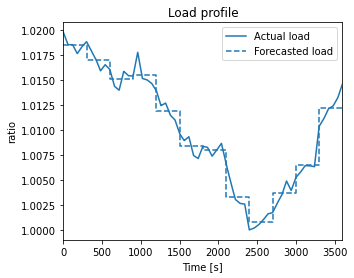

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 4
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = ratio*(d_syn['ph10'] - d_syn['ph10'].min()) / d_syn['h10'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0997 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916785548
2: |F(x)| = 0.1314169328
3: |F(x)| = 0.0003491192315
4: |F(x)| = 4.240441775e-09
Converged in 5 iterations in 0.0037 seconds.
Power flow results are consistent. Conversion is successful.


True

In [8]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,153.180,1.0,False,True,0.0,None,True,200.0,1500.0,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,429.804,1.0,False,True,0.0,None,True,150.0,900.0,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,446.722,1.0,False,True,0.0,None,True,100.0,800.0,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,548.208,1.0,False,True,0.0,None,True,100.0,700.0,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,611.495,1.0,False,True,0.0,None,True,100.0,700.0,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,593.788,1.0,False,True,0.0,None,True,100.0,800.0,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,568.372,1.0,False,True,0.0,None,True,100.0,700.0,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,443.468,1.0,False,True,0.0,None,True,100.0,700.0,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,834.775,1.0,False,True,0.0,None,True,100.0,1000.0,NaN
9,PV_10,37,-50.000000,1.052803,100.0,0.000,0.000,1.0,False,True,0.0,None,False,-60.0,70.0,NaN


Build RTED instance ``ssd``

In [9]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
ssd.def_type2(['PV_10'], [0], [0])

# set ramp5
ramp_hour = [240, 240, 120, 100, 140, 60, 68, 44, 40, 999, 360]
ssd.gen.ramp5 = np.array(ramp_hour) / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# update p_pre from DCOPF results
ssd.set_p_pre()

# sovle the model
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0028 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916785548
2: |F(x)| = 0.1314169328
3: |F(x)| = 0.0003491192315
4: |F(x)| = 4.240441775e-09
Converged in 5 iterations in 0.0031 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xd0e3d6f3
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 53 rows and 3 columns
Presolve time: 0.00s
Presolved: 16 rows, 14 columns, 128 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   8.040153e+01   0.000000e+00      0s
      15    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp cost data (``cru`` in ``cost``), set to 0.
No RegDn cost data(``crd`` in ``cost``), set to 0.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x1ccd3f5a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [3e-01, 6e+01]
Presolve removed 113 rows and 27 columns
Presolve time: 0.00s
Presolved: 4 rows, 6 columns, 24 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   6.907995e-01   0.000000e+00      0s
       5    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,12.646738,0.0,0.0,0.0,0.0
1,PV_2,6.191355,0.0,0.0,0.0,0.0
2,PV_3,7.900000,0.0,0.0,0.0,0.0
3,PV_4,5.934429,0.0,0.0,0.0,0.0
4,PV_5,7.000000,0.0,0.0,0.0,0.0
5,PV_6,4.800000,0.0,0.0,0.0,0.0
6,PV_7,3.558145,0.0,0.0,0.0,0.0
7,PV_8,7.000000,0.0,0.0,0.0,0.0
8,PV_9,1.033333,0.0,0.0,0.0,0.0
9,PV_10,-0.500000,0.0,0.0,0.0,0.0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [10]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xd0e3d6f3
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 53 rows and 3 columns
Presolve time: 0.00s
Presolved: 16 rows, 14 columns, 128 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   8.040153e+01   0.000000e+00      0s
      15    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.


pp cost=6006.400000039296, gb cost=60.06399999999999


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,957.279198,91.721528,16.616789,1.0,1262.092391
1,688.587174,311.370989,7.899886,1.0,629.050241
2,598.040438,149.293426,9.171747,1.0,800.000000
3,525.749647,131.004236,8.870111,1.0,585.109579
4,525.827128,146.497277,8.472817,1.0,700.000000
5,599.113874,227.597221,11.806162,1.0,480.000000
6,521.200723,63.133957,14.657381,1.0,350.147789
7,428.297585,-27.033467,12.225390,1.0,700.000000
8,762.304233,116.236721,13.822828,1.0,100.000000
9,-50.000000,0.000000,13.822828,1.0,-50.000000


## Prepare

### Make link table

In [11]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [12]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp)
    load_u = abs(load_ci[1] - load_exp)
    return load_u, load_d, load_exp

## Define param

In [13]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.001 # 0.05
Ki = 0.0001
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [14]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 1

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(400):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva
        ssd.load['p0'] = ssa_p0 * load_exp

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                         right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            # reset initial setpoints as the DCOPF results
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre':'pe', 'idx':'stg_idx'})
        
        # TODO: INPUT cost and ramp, ramp should be p.u.
        ssd.def_sfr(du=du, dd=dd)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.pe_tds
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.1].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.pe_tds + ssp_res.pref_delta
        # update SynGen setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # update DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x0d7bf2af
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 53 rows and 3 columns
Presolve time: 0.00s
Presolved: 16 rows, 14 columns, 128 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1146513e+01   8.162561e+01   0.000000e+00      0s
      15    6.1146513e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.114651339e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xc48b96f2
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [5e-05, 6e+01]
Presolve removed 113 rows and 27 columns
Presolve time: 0.00s
Presolved: 4 rows, 6 columns, 24 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1146513e+01   6.920363e-01   0.000000e+00      0s
       6    6.1146513e+01   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.114651339e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0030 seconds.
0: |F(x)| = 9.931477425
1: |F(x)| = 2.923788241
2: |F(x)| = 0.1459090548
3: |F(x)| = 0.0004692550663
4: |F(x)| = 9.479350638e-09
Converged in 5 iterations in 0.0035 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.012  | 0.001
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_8  | 0.

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0026 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0610 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0528 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0605 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0576 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0569 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0605 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0603 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0591 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0586 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0606 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0579 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0558 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0615 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0557 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0614 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0552 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0614 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0556 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0561 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0574 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0610 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0589 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0563 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0616 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0595 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0616 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0582 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0596 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0598 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0614 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0586 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0551 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0571 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0571 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0550 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0530 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0585 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0549 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0513 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0500 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0353 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0341 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0331 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0351 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0351 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0369 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0344 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0342 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0362 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x24539ab1
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [1e-04, 6e+01]
Presolve removed 113 rows and 26 columns
Presolve time: 0.00s
Presolved: 4 rows, 7 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1059278e+01   2.547041e-01   0.000000e+00      0s
       2    6.1059278e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.105927785e+01


Successfully solve RTED.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0491 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0343 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0332 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0333 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0510 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0345 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0506 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0351 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0353 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0579 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0348 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0511 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0527 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0345 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0472 seconds.
/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_94855/999322095.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0580 seconds.


[Text(0.5, 51.00000000000006, 'Deviation [p.u.]'), Text(761.8, 0.5, '')]

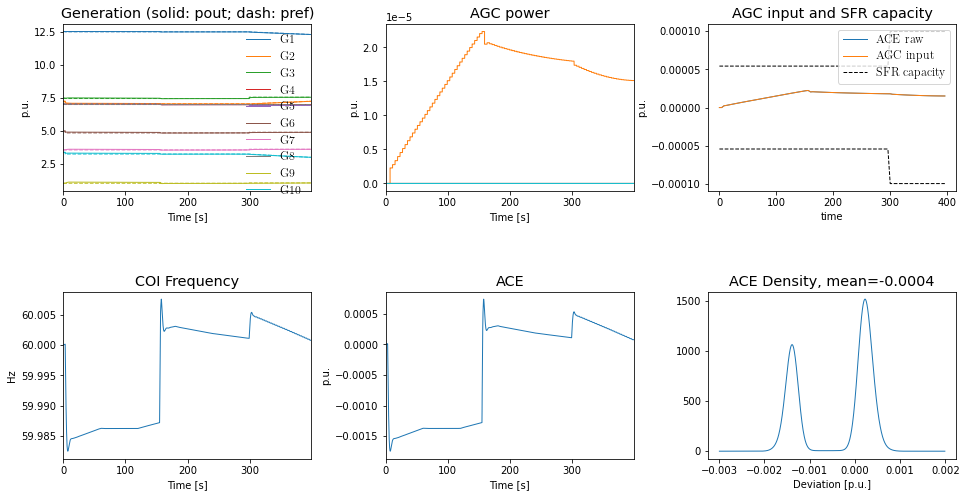

In [15]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)

yheader = [f'G{i}' for i in range(1,11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='ace',
            title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')